This notebook extracts the tool changes on UseGalaxy.eu from the news (https://usegalaxy-eu.github.io/news)

In [1]:
import re
import os

from dotenv import load_dotenv
from github import Github
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [2]:
color = "#eaac88"

In [3]:
# Load environment variables from .env file
load_dotenv()

True

In [4]:
figure_dp = Path("../figures/")
figure_dp.mkdir(parents=True, exist_ok=True)

data_dp = Path("../data/")
data_dp.mkdir(parents=True, exist_ok=True)

In [5]:
# Initialize GitHub
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
if not GITHUB_TOKEN:
    raise ValueError("❌ GITHUB_TOKEN environment variable not set!")
g = Github(GITHUB_TOKEN)

REPO_NAME = "usegalaxy-eu/website"
repo = g.get_repo(REPO_NAME)

In [6]:
# Regex patterns
date_pattern = re.compile(r'^(\d{4}-\d{2}-\d{2})-tool-update\.md$')
updated_line = re.compile(r'^\s*-\s+.*was\s+updated\s+to', re.IGNORECASE)
added_line = re.compile(r'^\s*-\s+.*was\s+(?:added|installed)', re.IGNORECASE)

In [7]:
# Fetch files from the repo
contents = repo.get_contents("_posts")
files = [f for f in contents if date_pattern.match(f.name)]

if not files:
    print("❌ No files matched; check the repo and folder path!")
    exit(1)

print("Scanning these posts:")
for file in files:
    print("  ", file.name)

Scanning these posts:
   2019-04-06-tool-update.md
   2019-04-23-tool-update.md
   2019-06-06-tool-update.md
   2019-06-08-tool-update.md
   2019-06-15-tool-update.md
   2019-06-21-tool-update.md
   2019-06-27-tool-update.md
   2019-07-06-tool-update.md
   2019-07-13-tool-update.md
   2019-07-19-tool-update.md
   2019-07-27-tool-update.md
   2019-08-03-tool-update.md
   2019-08-10-tool-update.md
   2019-08-18-tool-update.md
   2019-08-24-tool-update.md
   2019-08-31-tool-update.md
   2019-09-07-tool-update.md
   2019-09-14-tool-update.md
   2019-09-21-tool-update.md
   2019-09-29-tool-update.md
   2019-10-05-tool-update.md
   2019-10-12-tool-update.md
   2019-10-17-tool-update.md
   2019-10-19-tool-update.md
   2019-11-10-tool-update.md
   2019-11-15-tool-update.md
   2019-11-22-tool-update.md
   2019-11-30-tool-update.md
   2019-12-07-tool-update.md
   2019-12-14-tool-update.md
   2019-12-21-tool-update.md
   2019-12-28-tool-update.md
   2020-01-04-tool-update.md
   2020-01-11-tool-up

In [8]:
# Prepare a list to collect rows
rows = []
for file in files:
    # Extract date from filename
    m = date_pattern.match(file.name)
    date = m.group(1) if m else file.name[:10]

    # Fetch file content
    content = file.decoded_content.decode("utf-8")

    # Count lines
    new_count = 0
    updated_count = 0
    for line in content.splitlines():
        if updated_line.match(line):
            updated_count += 1
        elif added_line.match(line):
            new_count += 1

    rows.append({"date": date, "new_count": new_count, "updated_count": updated_count})

In [9]:
# Convert to pandas DataFrame
df = pd.DataFrame(rows).sort_values("date")
df["date"] = pd.to_datetime(df["date"])
df["updated_cum_count"] = df["updated_count"].cumsum()
df["new_cum_count"] = df["new_count"].cumsum()
df.to_csv(data_dp / Path("tool_changes.csv"))
df

,date,new_count,updated_count,updated_cum_count,new_cum_count
0,2019-04-06,0,422,422,0
1,2019-04-23,0,423,845,0
2,2019-06-06,0,52,897,0
3,2019-06-08,0,14,911,0
4,2019-06-15,0,7,918,0
...,...,...,...,...,...
336,2025-08-03,0,0,20308,0
337,2025-08-11,0,104,20412,0
338,2025-08-18,0,109,20521,0
339,2025-08-24,0,22,20543,0


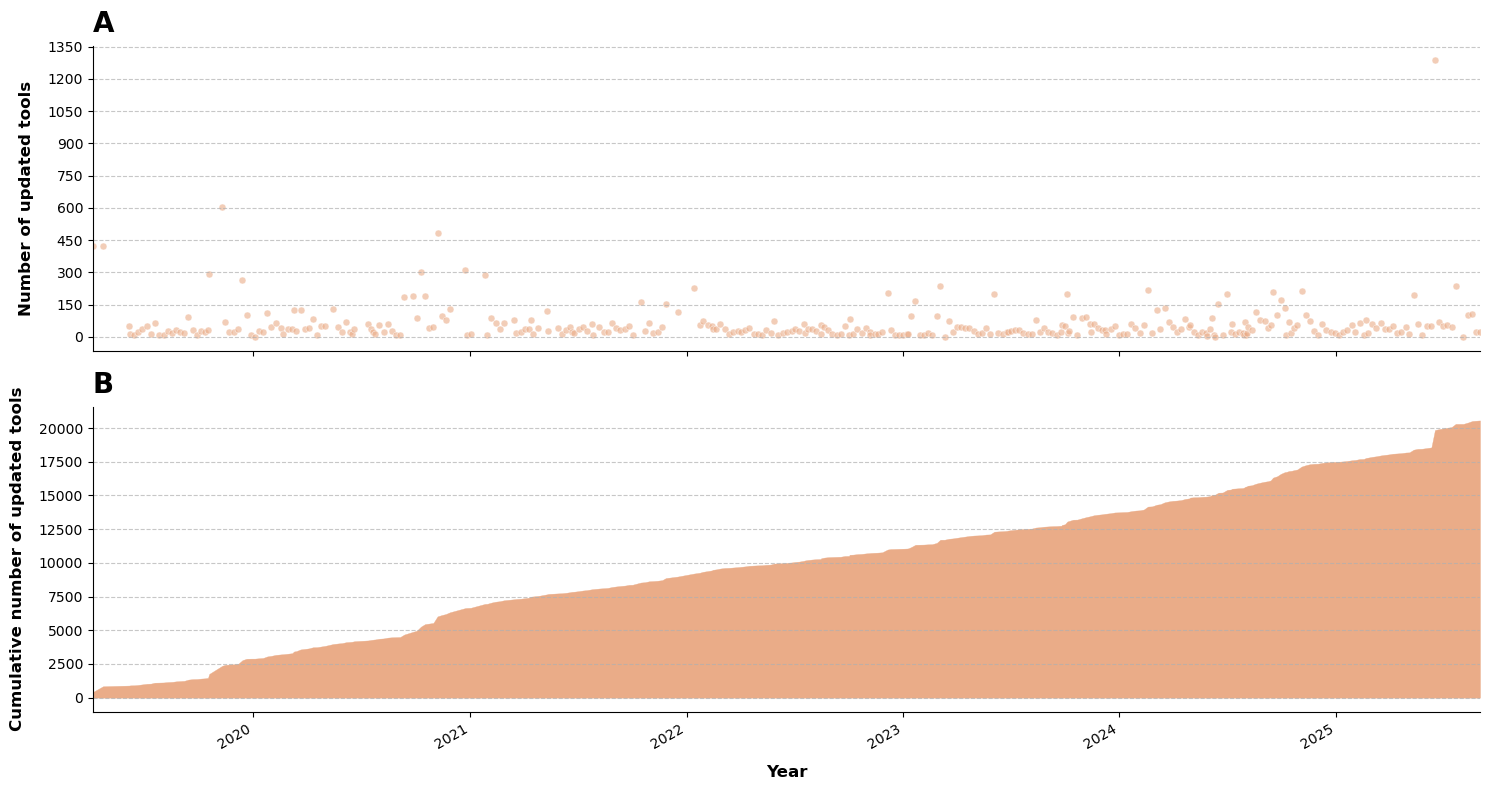

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Common styling

dot_opts = dict(s=25, alpha=0.6, color=color, edgecolor="white", linewidth=0.5)
line_opts = dict(linewidth=2, alpha=0.8, color=color)

# (a) Daily updated count
ax1.scatter(df["date"], df["updated_count"], **dot_opts)
ax1.set_title("A", fontsize=20, fontweight='bold', loc="left", pad=10)
ax1.set_ylabel("Number of updated tools", fontsize=12, fontweight='bold', labelpad=10)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax1.grid(axis='y', linestyle='dashed', alpha=0.7, which='both')
ax1.grid(axis='x', which='both', visible=False)
ax1.set_facecolor('white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# (b) Cumulative updated count
ax2.fill_between(
    df["date"],
    df["updated_cum_count"],
    color=color,
    linewidth=0.25,
    edgecolor=color,
)
ax2.set_title("B", fontsize=20, fontweight='bold', loc="left", pad=10)
ax2.set_ylabel("Cumulative number of updated tools", fontsize=12, fontweight='bold', labelpad=10)
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.grid(axis='y', linestyle='dashed', alpha=0.7, which='both')
ax2.grid(axis='x', which='both', visible=False)
ax2.set_facecolor('white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Common X label and formatting
for ax in (ax1, ax2):
    ax.set_xlabel("Year", fontsize=12, fontweight='bold', labelpad=10)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlim(df["date"].min(), df["date"].max())

# Vertical lines (if you want to add them for specific dates)
for year in [2010, 2015, 2017, 2020, 2023]:
    ax1.axvline(x=year, color='white', linestyle='dotted', linewidth=0.5)
    ax2.axvline(x=year, color='white', linestyle='dotted', linewidth=0.5)

fig.autofmt_xdate()
fig.set_facecolor('white')
plt.tight_layout()

# Save as PNG
fig.savefig( figure_dp / "updated_tools.png", dpi=300, bbox_inches='tight')

plt.show()